In [2]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob

# Loading the dataset
file_path = 'cleaned_metoo_tweets.csv'  
data = pd.read_csv(file_path)

In [3]:
data.head()

,id,created,cleaned_text
0,9.360000e+17,2017-11-29T23:59:00,american harem metoo
1,9.360000e+17,2017-11-29T23:59:00,why have you guys not resigned yet liberal hyp...
2,9.360000e+17,2017-11-29T23:59:00,watched megan kelly ask joe keery m if she can...
3,9.360000e+17,2017-11-29T23:59:00,women have been talking about crap entire time...
4,9.360000e+17,2017-11-29T23:59:00,please speak sexual assault by during intervie...


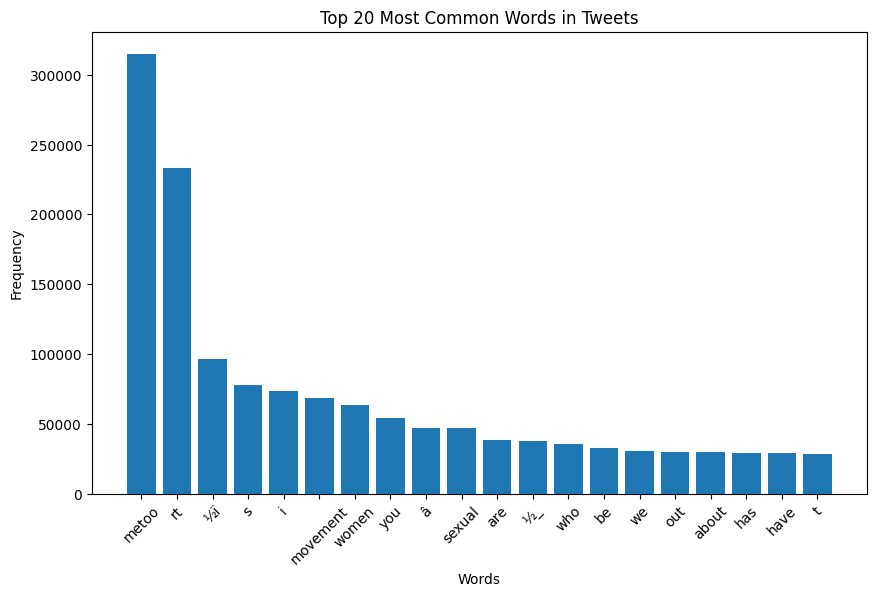

In [4]:
# Tokenizing the cleaned text and count word frequencies
def tokenize(text):
    return text.split()

all_words = [word for text in data['cleaned_text'].dropna() for word in tokenize(text)]
word_counts = Counter(all_words)

# Listing Top 20 most common words
common_words = word_counts.most_common(20)
words, counts = zip(*common_words)

# Plotting the keyword frequency
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.title("Top 20 Most Common Words in Tweets")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

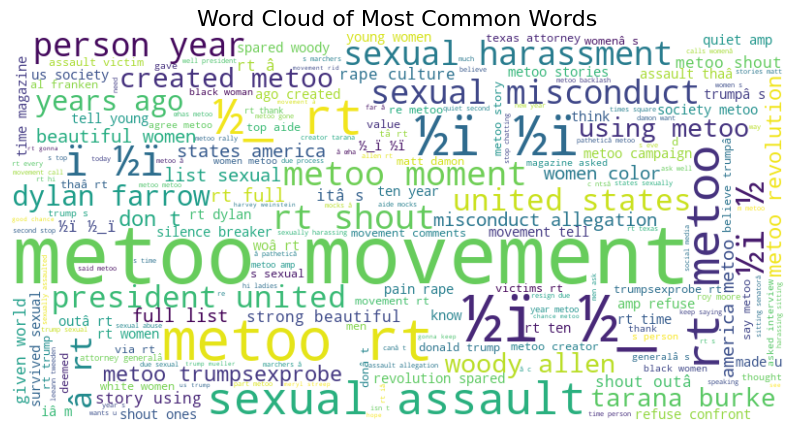

In [5]:
# Combining all the text from the cleaned_text column into a single string
all_text = ' '.join(data['cleaned_text'].dropna())

# Creating the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Displaying the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Most Common Words", fontsize=16)
plt.show()

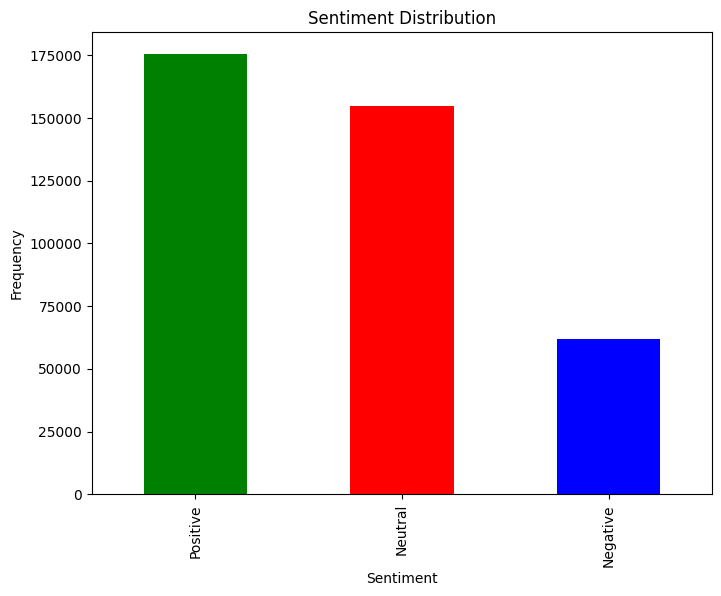

In [6]:
# Functions to classify sentiment
def classify_sentiment(text):
    sentiment = TextBlob(text).sentiment.polarity
    if sentiment > 0:
        return "Positive"
    elif sentiment < 0:
        return "Negative"
    else:
        return "Neutral"

# Applying sentiment classification
data['sentiment'] = data['cleaned_text'].dropna().apply(classify_sentiment)

# Ploting sentiment distribution
sentiment_counts = data['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()


['2017-11-29T23:59:00' '2017-11-29T23:58:00' '2017-11-29T23:57:00' ...
 '2017-12-25T00:02:00' '2017-12-25T00:01:00' '2017-12-25T00:00:00']


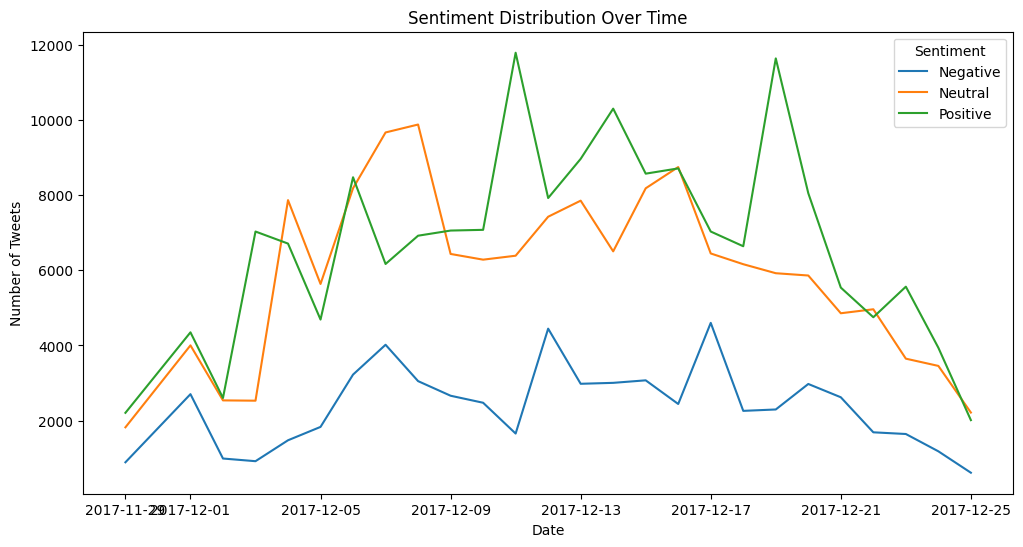

In [7]:
# Inspect unique values in the 'created' column to identify invalid entries
print(data['created'].unique())

# Removing invalid date rows and convert 'created' to datetime
def clean_date_column(date_column):
    valid_dates = pd.to_datetime(date_column, errors='coerce')  # Convert valid dates; set invalid to NaT
    return valid_dates

data['created'] = clean_date_column(data['created'])

# Droping rows with invalid dates (NaT)
data = data.dropna(subset=['created'])

# Grouping by date and sentiment
sentiment_over_time = data.groupby([data['created'].dt.date, 'sentiment']).size().unstack()

# Plot sentiment distribution over time
sentiment_over_time.plot(figsize=(12, 6))
plt.title("Sentiment Distribution Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.legend(title="Sentiment")
plt.show()

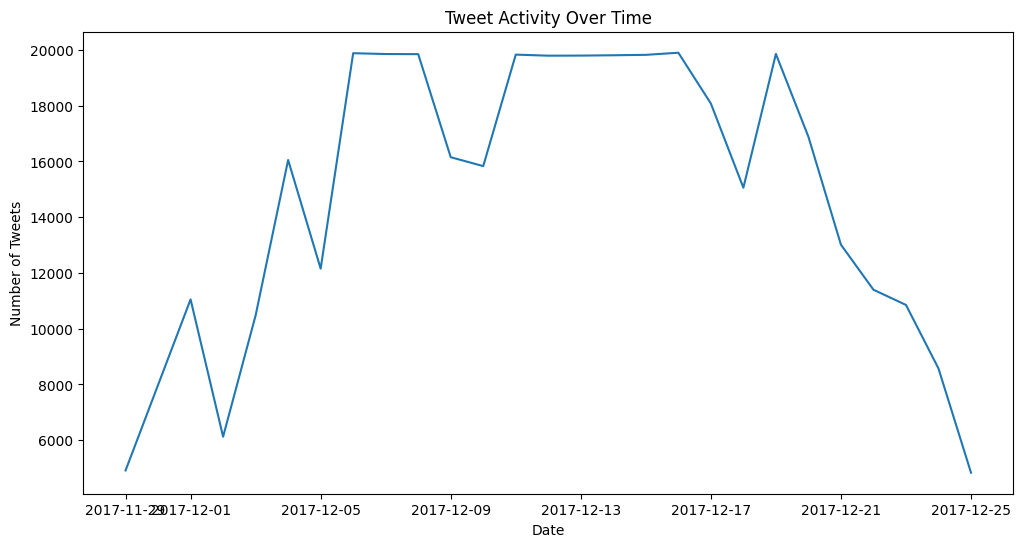

In [8]:
# Grouping the tweets by day
tweet_activity = data['created'].dt.date.value_counts().sort_index()

# Ploting tweets activity
plt.figure(figsize=(12, 6))
tweet_activity.plot()
plt.title("Tweet Activity Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Tweets")
plt.show()

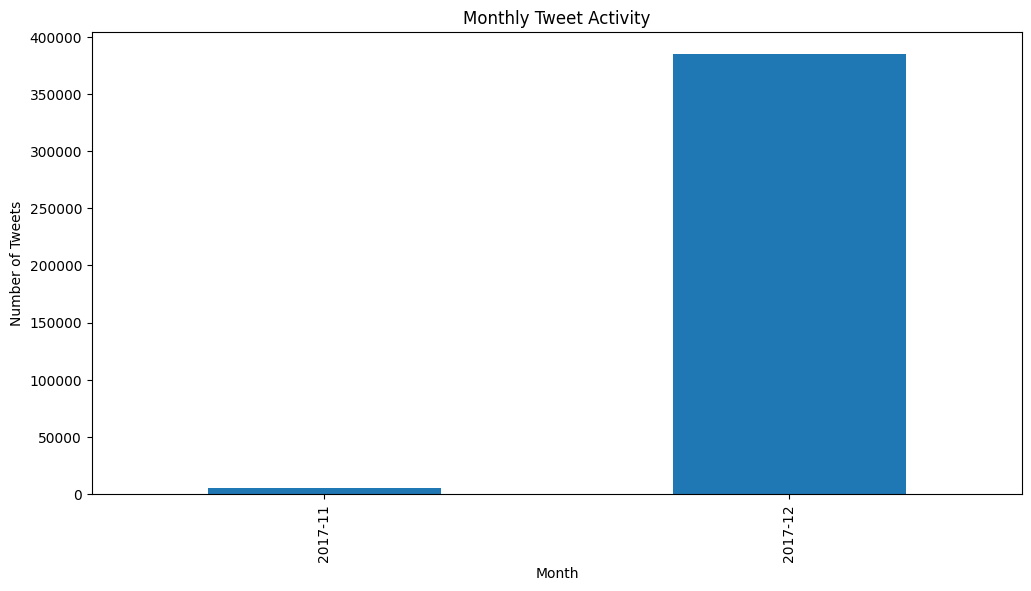

In [9]:
# Grouping the tweets by month
monthly_activity = data['created'].dt.to_period('M').value_counts().sort_index()

# Ploting monthly tweet activity
plt.figure(figsize=(12, 6))
monthly_activity.plot(kind='bar')
plt.title("Monthly Tweet Activity")
plt.xlabel("Month")
plt.ylabel("Number of Tweets")
plt.show()

Interactive visualization for LDA saved as 'lda_visualization_gensim.html'.
Top NMF Topics:
Topic 0: rt, metoo, sexual, assault, movement, allegations, president, misconduct, united, states
Topic 1: shout, outâ, beautiful, given, strong, using, world, story, women, confront
Topic 2: ½ï, ½_, metoo, ½_ï, rt, year, person, time, movement, ½ûªs


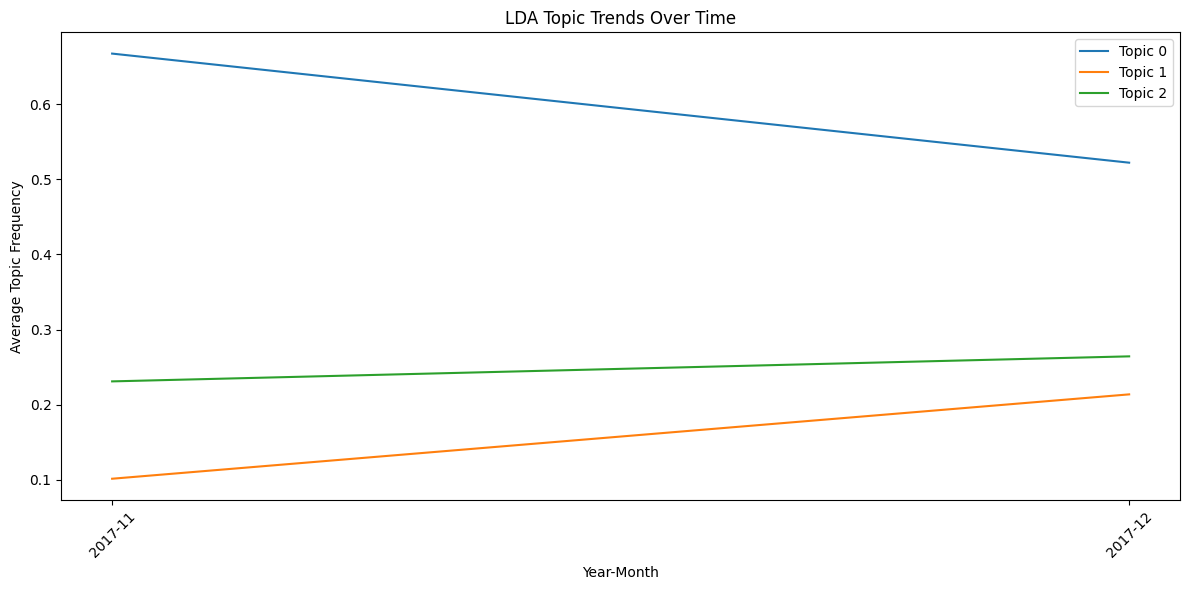

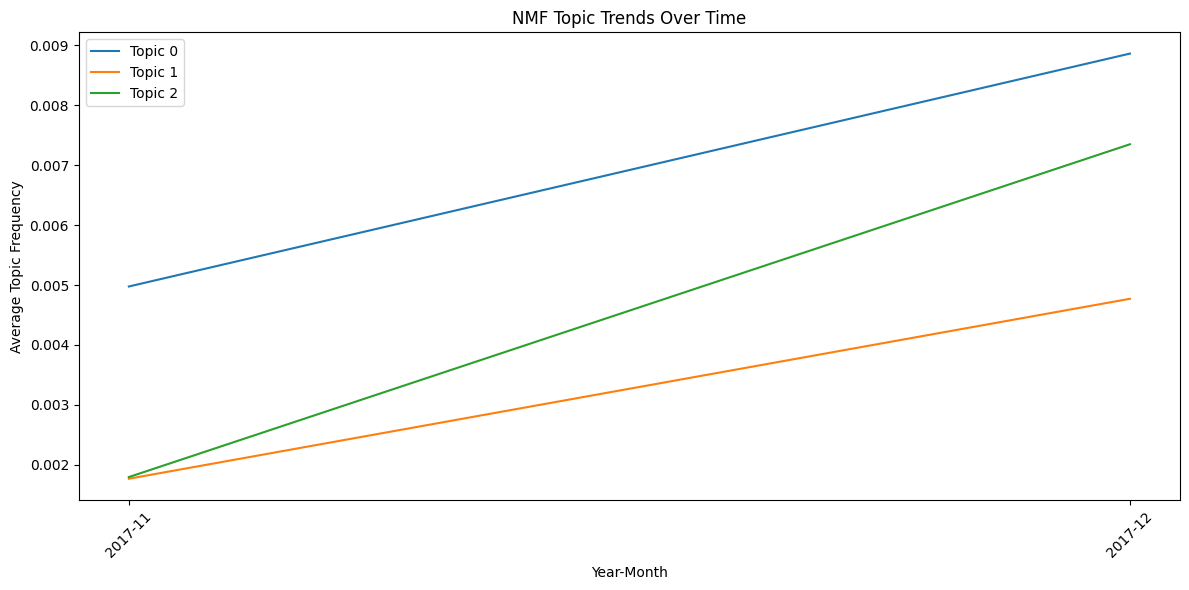

In [3]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import corpora, models

# Load the dataset
file_path = 'cleaned_metoo_tweets.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Extract and preprocess the 'cleaned_text' column
texts_raw = data['cleaned_text'].dropna().tolist()

# Basic preprocessing function
def preprocess_text(text):
    return re.findall(r'\b\w+\b', text.lower())

data['processed_text'] = data['cleaned_text'].apply(preprocess_text)

# Gensim preprocessing for LDA
texts_processed = data['processed_text']
dictionary = corpora.Dictionary(texts_processed)
doc_term_matrix = [dictionary.doc2bow(text) for text in texts_processed]

# LDA Model using Gensim
lda_model = models.LdaModel(doc_term_matrix, num_topics=3, id2word=dictionary, passes=20, random_state=42)

# Interactive Visualization with pyLDAvis for LDA
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(lda_vis, "lda_visualization_gensim.html")
print("Interactive visualization for LDA saved as 'lda_visualization_gensim.html'.")

# Preprocess data for NMF (using TF-IDF Vectorizer)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_data = tfidf_vectorizer.fit_transform(data['cleaned_text'].dropna())

# NMF Model
nmf_model = NMF(n_components=3, random_state=42, max_iter=200)
nmf_topics = nmf_model.fit_transform(tfidf_data)

# Extract Top Words for NMF
def get_top_words(model, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f"Topic {topic_idx}"] = top_words
    return topics

nmf_top_words = get_top_words(nmf_model, tfidf_vectorizer.get_feature_names_out())

# Display NMF topics
print("Top NMF Topics:")
for topic, words in nmf_top_words.items():
    print(f"{topic}: {', '.join(words)}")

# Topical Trends Over Time (LDA Example)
data['created'] = pd.to_datetime(data['created'])
data['year_month'] = data['created'].dt.to_period('M')

lda_topic_trends = pd.DataFrame([
    {f"Topic {i}": prob for i, prob in lda_model[doc]} for doc in doc_term_matrix
])
lda_topic_trends['year_month'] = data['year_month'].values

trend_data_lda = lda_topic_trends.groupby('year_month').mean()

# Plot LDA Topic Trends Over Time
plt.figure(figsize=(12, 6))
for col in trend_data_lda.columns:
    plt.plot(trend_data_lda.index.astype(str), trend_data_lda[col], label=col)
plt.xlabel('Year-Month')
plt.ylabel('Average Topic Frequency')
plt.title('LDA Topic Trends Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# NMF Topic Trends (Optional)
nmf_topic_trends = pd.DataFrame(nmf_topics, columns=[f"Topic {i}" for i in range(nmf_topics.shape[1])])
nmf_topic_trends['year_month'] = data['year_month'].values

trend_data_nmf = nmf_topic_trends.groupby('year_month').mean()

# Plot NMF Topic Trends Over Time
plt.figure(figsize=(12, 6))
for col in trend_data_nmf.columns:
    plt.plot(trend_data_nmf.index.astype(str), trend_data_nmf[col], label=col)
plt.xlabel('Year-Month')
plt.ylabel('Average Topic Frequency')
plt.title('NMF Topic Trends Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
from gensim import corpora, models

# Load the dataset
file_path = 'cleaned_metoo_tweets.csv'  # Replace with your dataset path
data = pd.read_csv(file_path)

# Extract and preprocess the 'cleaned_text' column
texts_raw = data['cleaned_text'].dropna().tolist()

# Basic preprocessing function
def preprocess_text(text):
    return re.findall(r'\b\w+\b', text.lower())

data['processed_text'] = data['cleaned_text'].apply(preprocess_text)

# Gensim preprocessing for LDA
texts_processed = data['processed_text']
dictionary = corpora.Dictionary(texts_processed)
doc_term_matrix = [dictionary.doc2bow(text) for text in texts_processed]

# LDA Model using Gensim
lda_model = models.LdaModel(doc_term_matrix, num_topics=3, id2word=dictionary, passes=20, random_state=42)

# Interactive Visualization with pyLDAvis for LDA
lda_vis = pyLDAvis.gensim_models.prepare(lda_model, doc_term_matrix, dictionary)
pyLDAvis.save_html(lda_vis, "lda_visualization_gensim.html")
print("Interactive visualization for LDA saved as 'lda_visualization_gensim.html'.")

# Preprocess data for NMF (using TF-IDF Vectorizer)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_data = tfidf_vectorizer.fit_transform(data['cleaned_text'].dropna())

# NMF Model
nmf_model = NMF(n_components=3, random_state=42, max_iter=200)
nmf_topics = nmf_model.fit_transform(tfidf_data)

# Extract Top Words for LDA and NMF
def get_top_words(model, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f"Topic {topic_idx}"] = top_words
    return topics

lda_top_words = {f"Topic {i}": [word for word, _ in lda_model.show_topic(i, topn=10)] for i in range(3)}
nmf_top_words = get_top_words(nmf_model, tfidf_vectorizer.get_feature_names_out())

print("LDA Topics:")
for topic, words in lda_top_words.items():
    print(f"{topic}: {', '.join(words)}")

print("NMF Topics:")
for topic, words in nmf_top_words.items():
    print(f"{topic}: {', '.join(words)}")

# Combine Topics from Both Models
combined_topics = {}
for i in range(3):
    combined_topics[f"Combined Topic {i}"] = list(set(lda_top_words[f"Topic {i}"] + nmf_top_words[f"Topic {i}"]))

print("\nCombined Topics:")
for topic, words in combined_topics.items():
    print(f"{topic}: {', '.join(words)}")

# Generate Sentences from Combined Topics
generated_sentences = [" ".join(words) for words in combined_topics.values()]

print("\nGenerated Sentences:")
for i, sentence in enumerate(generated_sentences):
    print(f"Sentence {i + 1}: {sentence}")

# Match Sentences to Dataset
data['matches'] = data['cleaned_text'].apply(
    lambda x: [sentence for sentence in generated_sentences if all(word in x for word in sentence.split())]
)

# Display Rows with Matches
matched_data = data[data['matches'].str.len() > 0]

# Save matched results
matched_data.to_csv("matched_results.csv", index=False)

print(f"\nMatched rows saved to 'matched_results.csv'.")


Interactive visualization for LDA saved as 'lda_visualization_gensim.html'.
LDA Topics:
Topic 0: metoo, rt, i, you, t, are, we, her, who, be
Topic 1: metoo, ½ï, rt, s, year, ï, 2017, â, movement, ½
Topic 2: metoo, rt, sexual, â, s, movement, harassment, moment, from, after
NMF Topics:
Topic 0: rt, metoo, sexual, assault, movement, allegations, president, misconduct, united, states
Topic 1: shout, outâ, beautiful, given, strong, using, world, story, women, confront
Topic 2: ½ï, ½_, metoo, ½_ï, rt, year, person, time, movement, ½ûªs

Combined Topics:
Combined Topic 0: are, president, we, t, movement, rt, allegations, metoo, i, be, sexual, who, misconduct, her, united, assault, you, states
Combined Topic 1: movement, using, beautiful, â, shout, 2017, metoo, ½ï, ï, story, given, confront, outâ, women, world, rt, strong, year, ½, s
Combined Topic 2: movement, rt, time, after, metoo, year, ½ûªs, sexual, ½_ï, moment, from, harassment, ½ï, s, person, ½_, â

Generated Sentences:
Sentence 1: are